In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' # Gets rid of SettingWithCopy warnings
pd.options.display.float_format = '{:.1f}'.format # only print one decimal place

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

## Load Forecast Data

In [2]:
people = pd.read_csv('../data/forecast/people.csv', 
                          index_col='id', 
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

people.shape

(26, 22)

In [3]:
projects = pd.read_csv('../data/forecast/projects.csv', 
                          index_col='id', 
                          parse_dates=['updated_at','start_date','end_date'],
                          infer_datetime_format=True)

projects.shape

(90, 12)

In [4]:
placeholders = pd.read_csv('../data/forecast/placeholders.csv', 
                          index_col='id',
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

placeholders.shape

(8, 5)

In [5]:
clients = pd.read_csv('../data/forecast/clients.csv', 
                          index_col='id', 
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

clients.shape

(29, 5)

In [6]:
assignments = pd.read_csv('../data/forecast/assignments.csv', 
                          index_col='id', 
                          parse_dates=['start_date','end_date','updated_at'],
                          infer_datetime_format=True)

assignments['allocation'] = assignments['allocation']/(8*60*60)
assignments.shape

(177, 11)

## Functions to merge and display data on people's allocations

In [16]:
# Group the assignments by person
grouped_allocations = assignments.groupby(['person_id','project_id','start_date','end_date']).allocation.sum()

# Find the earliest and latest date in the data
date_range = pd.date_range(start=assignments['start_date'].min(),
                           end=assignments['end_date'].max(),
                           freq='D')


def get_person_name(person_id):
    """Get the full name of someone from their person_id"""
    return people.loc[person_id,'first_name'] + ' ' + people.loc[person_id, 'last_name']


def get_person_id(first_name, last_name=None):
    """Get the person_id of someone from their first_name and last_name."""
    if last_name is None:
        person_id = people.loc[(people['first_name']==first_name)]
    
        if len(person_id) != 1:
            raise ValueError('Could not unique person with name '+first_name)

    else:
        person_id = people.loc[(people['first_name']==first_name) & (people['last_name']==last_name)]
    
        if len(person_id) != 1:
            raise ValueError('Could not unique person with name '+first_name+' '+last_name)

    return person_id.index[0]


def get_project_name(project_id):
    """Get the name of a project from its project_id"""
    return projects.loc[project_id, 'name']


def select_date_range(df, start_date, end_date): 
    """Extract a range of dates from a dataframe with a datetime index, 
    then remove any columns which are left empty (full of zeros)."""
    mask = (df.index >= start_date) & (df.index <= end_date)
    df_slice = df.loc[mask]
    
    nonzero_cols = df_slice.columns[df_slice.sum()!=0]
    df_slice = df_slice[nonzero_cols]
        
    return df_slice


def get_person_allocations(person_id):
    """For one person, create a dataframe where the rows are days,
    the columns are projects, and the cell values are allocations
    as a fraction of an 8 hour day."""
    
    # check whether the person has any project assignments, i.e. whether the person
    # exists in the index (get_level_values to deal with MultiIndex)
    if person_id in grouped_allocations.index.get_level_values(0):
        # get the person's allocations
        person = grouped_allocations.loc[person_id]
        
        # unstack the MultiIndex
        person = person.reset_index()

        # Initialise dataframe to store results
        allocated_days = pd.DataFrame(index=date_range, columns=person.project_id.unique())
        allocated_days.fillna(0,inplace=True)

        # Loop over each project assignment
        for idx,row in person.iterrows():
            # Create the range of dates that this assignment corresponds to, with daily frequency
            dates = pd.date_range(start=row['start_date'], end=row['end_date'], freq='D')
            
            # Add the allocation to the corresponding project for the range of dates.
            allocated_days.loc[dates, row['project_id']] += row['allocation']

        # Add the person's name as a label - just nice for printing later.
        allocated_days.columns.name = get_person_name(person_id)
        
    else:
        # no projects, just make an empty dataframe..
        allocated_days = pd.DataFrame(index=date_range)
    
    return allocated_days


# dictionary containing each person's daily project allocations
people_allocations = {person_id: get_person_allocations(person_id) for person_id in people.index}    

# data frame containing each person's total daily allocation across all projects
people_totals = pd.DataFrame(index=date_range, columns=people.index)
for person_id in people_allocations.keys():
    people_totals[person_id] = people_allocations[person_id].sum(axis=1)
    

def plot_person_allocations(person_id, start_date, end_date):
    """Make a stacked area plot of a person's project allocations between
    a start date and an end date."""
    
    # get the person's project allocations
    df = people_allocations[person_id]
    
    # extract the date range of interest
    df = select_date_range(df, start_date, end_date)
    
    # replace project_ids in column names with their project names
    df.columns = [get_project_name(project_id) for project_id in df.columns]
    df.columns.name = get_person_name(person_id)
    
    # check whether there's anything to plot
    rows,cols = df.shape
    if rows>0 and cols>0:
        df = df.resample('W-MON').mean()

        # plot the data
        ax = plt.figure(figsize=(15,5)).gca()
        df.plot.area(ax=ax, linewidth=0)

        xlim = ax.get_xlim()
        plt.plot(xlim,[0.8, 0.8], 'k--', linewidth=3)
        plt.plot(xlim,[1, 1], 'k', linewidth=3)
        plt.xlim(xlim)
        plt.ylim([0, max([1, 1.1*df.sum(axis=1).max()])])

        plt.title(get_person_name(person_id))
        plt.ylabel('Proportion 8hr days')
        plt.xticks()
        plt.legend(title='',loc='best')
        plt.show()
        
    else:
        print('Nothing to plot.')


def highlight_allocations(df):
    """Function to conditionally style a data frame:
        Total allocations above 1.0 are highlighted red,
        above 0.8 orange, 0.8 yellow, and below 0.8 green.
        
        Individual project allocations are coloured blue when
        the person is active and grey when inactive on that project"""
    
    def highlight_tot(series):
        """function used to apply highlighting to the TOTAL column"""
        is_over = series>1.01
        is_marginal = (series>0.81) & (is_over==False)
        is_under = series<0.79

        style = []
        for i in range(len(series)):
            if is_over[i]:
                style.append('background-color: red')
            elif is_marginal[i]:
                style.append('background-color: orange')
            elif is_under[i]:
                style.append('background-color: lime')
            else:
                style.append('background-color: yellow')

        return style
    
    
    def highlight_active(series):
        """Function used to apply highlighting to all columns except the TOTAL column"""
        style=[]
        for i in range(len(series)):
            if series[i]>0:
                style.append('background-color: lightblue')
            else:
                style.append('background-color: dimgrey')
                
        return style
    
    # Apply the style. In order:
    #   - display percentages to nearest integer
    #   - centre align text
    #   - centre align and word wrap column names
    #   - conditional formatting for TOTAL column
    #   - conditional formatting for remaining columns
    return df.style.\
           format('{:.0%}').\
           set_properties(**{'text-align': 'center'}).\
           set_table_styles([dict(selector="th",props=[('max-width', '100px'), 
                                                       ('text-align','center')])]).\
           apply(highlight_active, subset=df.columns.drop('TOTAL')).\
           apply(highlight_tot, subset=['TOTAL'])


def table_person_allocations(person_id, start_date, end_date, freq='MS'):
    """Display a formatted table of a person's project allocations in a given
    date range, and with a certain date frequency. E.g. if freq='MS' each row
    will correspond to a month. 'D' for days, or 'W-MON' for weeks."""
    
    # extract the person's allocations, and replace ids with names
    df = people_allocations[person_id].copy()
    df.columns = [get_project_name(project_id) for project_id in df.columns]
    df.columns.name = get_person_name(person_id)
    
    # add the person's total project assignment to the data frame
    df['TOTAL'] = people_totals[person_id]

    # slice the given date range from the dataframe
    df = select_date_range(df, start_date, end_date)
    
    # check there's something to display
    rows,cols = df.shape
    if rows>0 and cols>0:
        # resample the rows to the given date frequency
        df = df.resample(freq).mean()

        # change date format for prettier printing
        df = pd.DataFrame(df, index=df.index.strftime("%Y-%m-%d"))

        # display the table
        display(highlight_allocations(df))
        
    else:
        print('Nothing to print.')

## Show Someone's Project Assignment

Dropdown(description='Person:', index=7, options=('Amaani Hoddoon', 'Amber Raza', 'Angus Williams', 'Camila Ra…

DatePicker(value=datetime.date(2018, 4, 1), description='Start Date:')

DatePicker(value=datetime.datetime(2020, 1, 1, 0, 0), description='End Date:')

RadioButtons(description='Frequency:', options=('Monthly', 'Weekly', 'Daily'), value='Monthly')

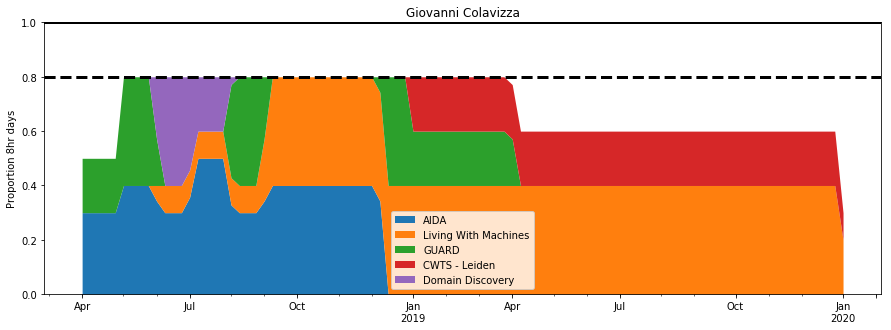

Giovanni Colavizza,AIDA,Living With Machines,GUARD,CWTS - Leiden,Domain Discovery,TOTAL
2018-04-01,30%,0%,20%,0%,0%,50%
2018-05-01,40%,0%,40%,0%,0%,80%
2018-06-01,30%,10%,0%,0%,40%,80%
2018-07-01,50%,10%,0%,0%,20%,80%
2018-08-01,30%,10%,40%,0%,0%,80%
2018-09-01,40%,40%,0%,0%,0%,80%
2018-10-01,40%,40%,0%,0%,0%,80%
2018-11-01,40%,40%,0%,0%,0%,80%
2018-12-01,12%,40%,28%,0%,0%,80%
2019-01-01,0%,40%,20%,20%,0%,80%


In [17]:
# dropdown list to select a person
widget_person = widgets.Dropdown(options=sorted([get_person_name(person_id) for person_id in people.index]),
                                 description='Person:')

# date picker to choose a start date
widget_start = widgets.DatePicker(
                    description='Start Date:',
                    value=pd.datetime(2019,1,1),
                    disabled=False
                )

# date picker to choose an end date
widget_end = widgets.DatePicker(
                    description='End Date:',
                    value=pd.datetime(2020,1,1),
                    disabled=False
                )

# radio buttons to choose the frequency of dates to display in the table
widget_freq = widgets.RadioButtons(
    options=['Monthly', 'Weekly', 'Daily'],
    value='Monthly',
    description='Frequency:',
    disabled=False
)



def widget_person_alloc(change):
    """Function called by widgets to update the person allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    display(widget_person, widget_start, widget_end, widget_freq)
    
    # get the person_id from the selected full name (need to first split into first and last names)
    names = widget_person.value.split()
    person_id = get_person_id(names[0], ' '.join(names[1:]))
    
    # get the selected dates
    start_date = pd.to_datetime(widget_start.value)
    end_date = pd.to_datetime(widget_end.value)
    
    # get the selected date frequency
    freq_dict = {'Monthly':'MS','Weekly':'W-MON','Daily':'D'}
    freq = freq_dict[widget_freq.value]
    
    # plot the person allocations
    plot_person_allocations(person_id, start_date, end_date)
    
    # print the person allocations table
    table_person_allocations(person_id, start_date, end_date, freq)

# setup the event listeners
widget_person.observe(widget_person_alloc, names='value')
widget_start.observe(widget_person_alloc, names='value')
widget_end.observe(widget_person_alloc, names='value')
widget_freq.observe(widget_person_alloc, names='value')

# display the widgets
display(widget_person, widget_start, widget_end, widget_freq)

## Show Everyone's Total Project Allocation Over Time

In [11]:
def highlight_tot(series):
    """Function used to apply conditional formatting to cells based on their values.
    Currently: below 0.8=green, 0.8=yellow, above 0.8=orange, above 1.0=red."""
    is_over = series>1.01
    is_marginal = (series>0.81) & (is_over==False)
    is_under = series<0.79

    style = []
    for i in range(len(series)):
        if is_over[i]:
            style.append('background-color: red')
        elif is_marginal[i]:
            style.append('background-color: orange')
        elif is_under[i]:
            style.append('background-color: lime')
        else:
            style.append('background-color: yellow')

    return style

# initialise df
df = people_totals

# mask used to select date range of interest
mask = (df.index >= pd.to_datetime(widget_start.value)) & (df.index <= pd.to_datetime(widget_end.value))

# extract slice of dates, and resample to monthly frequency
df = df[mask].resample('MS').mean()

# replace person ids with names
df.columns = [get_person_name(person_id) for person_id in df.columns]

# format dates nicely
df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))

# display the table with applied styling. In order:
#   - sort columns by first name, display percentages to nearest integer
#   - centre align text
#   - centre align and word wrap column names
#   - conditional formatting based on values
display(df[sorted(df.columns)].style.format('{:.0%}').\
         set_properties(**{'text-align': 'center'}).\
         set_table_styles([dict(selector="th",props=[('max-width', '100px'), 
                                                       ('text-align','center')])]).\
         apply(highlight_tot)) 

,Amaani Hoddoon,Amber Raza,Angus Williams,Camila Rangel Smith,David Beavan,Eric Daub,Evelina Gabasova,Giovanni Colavizza,Jack Roberts,James Geddes,James Hetherington,James Robinson,Jim Madge,Joel Dearden,Kasra Hosseini,Louise Bowler,Martin O'Reilly,May Yong,Miguel Morin,Nick Barlow,Oliver Strickson,Oscar Giles,Radka Jersakova,Sarah Gibson,Timothy Hobson,Tomas Lazauskas
Jan-2019,0%,0%,0%,80%,80%,72%,130%,80%,0%,80%,100%,80%,80%,0%,0%,80%,80%,80%,130%,80%,100%,0%,80%,80%,80%,80%
Feb-2019,0%,0%,0%,80%,80%,80%,130%,80%,0%,80%,100%,80%,80%,0%,39%,80%,80%,80%,130%,80%,100%,0%,80%,80%,80%,80%
Mar-2019,0%,0%,0%,80%,80%,75%,130%,80%,0%,80%,95%,75%,80%,0%,100%,80%,80%,80%,130%,80%,100%,0%,80%,80%,80%,80%
Apr-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,40%,20%,80%,40%,0%,0%,90%,0%,40%,130%,80%,50%,0%,80%,40%,80%,40%
May-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,40%,20%,80%,0%,0%,0%,90%,0%,40%,130%,80%,50%,0%,80%,40%,80%,40%
Jun-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,0%,20%,80%,0%,0%,0%,50%,0%,0%,0%,80%,0%,0%,80%,40%,80%,40%
Jul-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,0%,20%,80%,0%,0%,0%,50%,0%,0%,0%,80%,0%,0%,80%,40%,80%,40%
Aug-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,0%,20%,80%,0%,0%,0%,50%,0%,0%,0%,80%,0%,0%,40%,40%,80%,40%
Sep-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,0%,20%,80%,0%,0%,0%,50%,0%,0%,0%,80%,0%,0%,40%,40%,80%,40%
Oct-2019,0%,0%,0%,90%,80%,0%,130%,60%,0%,0%,20%,80%,0%,0%,0%,50%,0%,0%,0%,80%,0%,0%,40%,40%,80%,40%


To do:

Widgets for overall allocation table

Same views for projects

Include placeholders/resources from other groups

Team total available resource plot/table

Spreadsheet style tables, i.e. people as index and project names as values, projects as index and people names as values.